# 2. Estimate the Gas Mass By Hand

This notebook details methods used to obtain an estimate for the mass of the cold ALMA gas. We ectract S/N > 3 emission from each aperture and fit the spectra by hand. The result is used to estimate the h2 gas mass and depletion time. 

A. We fit the spectrum using `one to multiple gaussians` for a variety of velocity widths

B. Estimate the distribution of the gas mass for the variety of velocity widtha

C. check to see how different imaging schemes impact the total gas mass estimated

In [6]:
#path to beads
my_path = '/Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/'

In [7]:
#system
from __future__ import division
import sys
import importlib

#numpy
import numpy as np

#astropy
from astropy.cosmology import LambdaCDM
import astropy.units as u
from astropy.coordinates import Angle
import astropy.constants as const
from regions import Regions

#matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

#pv stuff

from spectral_cube import SpectralCube

#seaborn
import seaborn as sns

from matplotlib.gridspec import GridSpec
from astropy.wcs import WCS

#warnings
import warnings
warnings.filterwarnings("ignore")

In [8]:
#import my own functions: you can see them in full in the utils folder
util_path = my_path + 'Notebooks/Beads20/utils/'
sys.path.append(util_path)

import plotting_functions as pf
import science_functions as af

In [9]:
importlib.reload(af)

<module 'science_functions' from '/Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/Notebooks/Beads20/utils/science_functions.py'>

In [10]:
#About
name = 'SDSS J1531+3414'
ra = 232.7936938
dec = 34.2404172
radius = Angle(2.5, u.arcsec)

zh  = 0.335 #z selected from Hennawi (2008)
cz = zh * const.c.to('km/s')

In [11]:
cosmo = LambdaCDM(H0=71, Om0=0.27, Ode0=0.73)
da = cosmo.angular_diameter_distance(zh)
dl = cosmo.luminosity_distance(zh)

In [12]:

file_path = 'Analysis/almaBeads/cannon/'
co32_file = my_path + 'Analysis/almaBeads/reduced_2022/SDSS1531_CO32_20kms_natural_notaper.image.pbcor.fits'

m0_file = my_path + 'Analysis/almaBeads/reduced_2022/SDSS1531_CO32_20kms_natural_notaper.image.pbcor_M0.fits'

fig_path = my_path + 'Figures/paper/'

In [13]:
#plot style
#pf.styleplots(presentation=True)

## A. Estimate gas mass for cubes binned to different velocities
We used the ALMA data reduction pipeline to bin the ALMA cubes to different velocity resolutions of 10, 20, 40 and 80 km/s. We will obtain a gas mass estimate for each of these bins, to check if binning impacts our estimates by a significant amount


In [14]:
#list of cubes
velocity_resolutions = [10, 20, 40, 80]

vcube_files = [''.join((my_path, 'Analysis/almaBeads/reduced_2022/SDSS1531_CO32_{}kms_natural_notaper'
                        '.image.pbcor.fits'.format(vel))) for vel in velocity_resolutions]


In [15]:
#moment files for each cube
m0_files = [vfile[:-5]+ '_M0.fits' for vfile in vcube_files]
m1_files = [vfile[:-5]+ '_M1.fits' for vfile in vcube_files]
m2_files = [vfile[:-5]+ '_M2.fits' for vfile in vcube_files]

### Extract Spectra using Spectral-Cube and DS9

First, we draw apertures around the area we would like to fit using the mom0 map in DS9


In [16]:
region_string=""""
# Region file format: DS9 version 4.1
global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
fk5
# ellipse(232.7936870,34.2403494,0.977",1.532",337.76158)
# ellipse(232.7938088,34.2398737,1.554",1.936",325.57376)
# ellipse(232.7940692,34.2397661,0.834",1.474",19.996095)
# ellipse(232.7937700,34.2400595,1.702",2.613",345.09165)
ellipse(232.7936870,34.2403425,0.912",1.387",340.36443) #north
ellipse(232.7938088,34.2397973,0.959",0.870",327.30702) #center
ellipse(232.7940860,34.2397661,0.834",1.250",22.661828) #south
ellipse(232.7938130,34.2400682,1.400",2.363",335.34583) #total
"""

In [17]:
m0cmap, m1cmap, m2cmap =sns.light_palette("seagreen", as_cmap=True), cm.Blues,  sns.color_palette("mako_r", as_cmap=True)

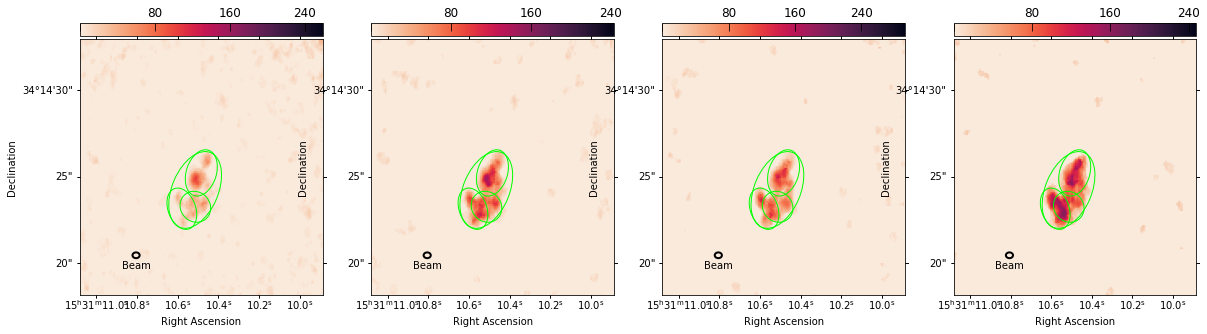

In [18]:
hdu, header, wcs = pf.open_fits(m0_files[0], naxis=2)
fig = pf.plot_all_moments(m0_files, header, region_string=region_string, ncols=4)

We can't resolve the individual beads, but `notebook 1` showed us there are 3 coherent structures present. We'll refer to them as `north, center and south`

In [19]:
lines = region_string.splitlines(keepends=False)[8:]

regions = [Regions.parse('fk5; {}'.format(line), format='ds9') for line in lines]


select emission in each region, for all 4 velocity resolutions

In [20]:
velocity_ranges = [[20, 220], [230, 440], [450, 660], [-680, 900]]
region_cubes = []

for idr, region_type in enumerate(regions):

    vap_cubes = []
    print('region: {}'.format(idr))

    for idv, vfile in enumerate(vcube_files):
        print('vel: {}'.format(idv))

        cube = SpectralCube.read(vfile)
    
        # vmin, vmax = velocity_ranges[idr][0], velocity_ranges[idr][1]
        # print(vmin, vmax)
        # subcube = cube.spectral_slab(vmin *(u.km/u.s), vmax*(u.km/u.s))
        ap_cube = cube.subcube_from_regions(region_type) 

        vap_cubes.append(ap_cube)

    region_cubes.append(vap_cubes)
    print('region: {}'.format(idr))

region: 0
vel: 0
vel: 1
vel: 2
vel: 3
region: 0
region: 1
vel: 0
vel: 1
vel: 2
vel: 3
region: 1
region: 2
vel: 0
vel: 1
vel: 2
vel: 3
region: 2
region: 3
vel: 0
vel: 1
vel: 2
vel: 3
region: 3


In [21]:
north_region_cubes = region_cubes[0]
center_region_cubes = region_cubes[1]
south_region_cubes = region_cubes[2]
total_region_cubes = region_cubes[3]


In [22]:
region_names = ['North', 'Center', 'South', 'Total']

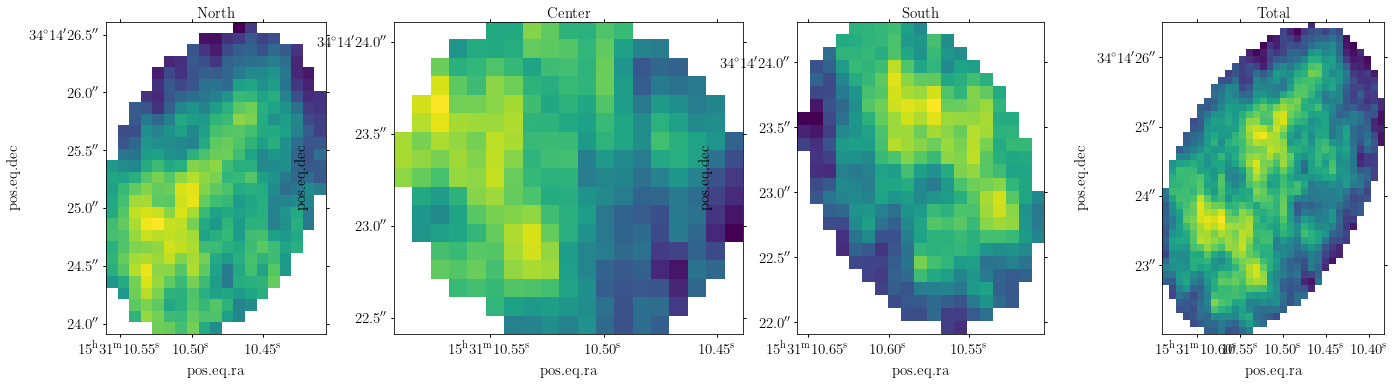

In [23]:
#check that the areas selected are correct
pf.styleplots()

fig = plt.figure(figsize=(20, 5))
gs1 = GridSpec(1,4)

plot_cubes = [north_region_cubes, center_region_cubes, south_region_cubes, total_region_cubes]

for idx in range(4):
    plot_cube = plot_cubes[idx][1]

    ax = fig.add_subplot(gs1[idx], projection=WCS(plot_cube.header), slices=('x', 'y', 0))
    ax.imshow(plot_cube.moment(order=0).data)
    ax.set_title(region_names[idx])

fig.tight_layout()



### Fit the total spectra by hand and estimate masses from fit and by direct integral of the data


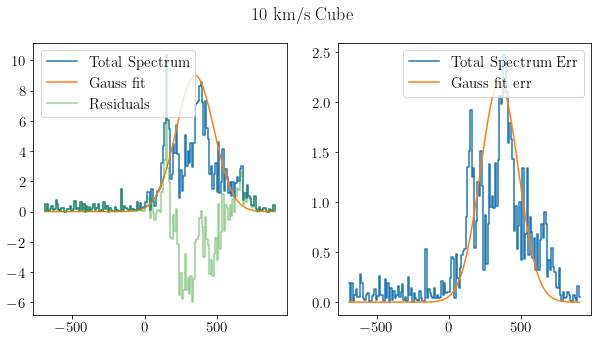

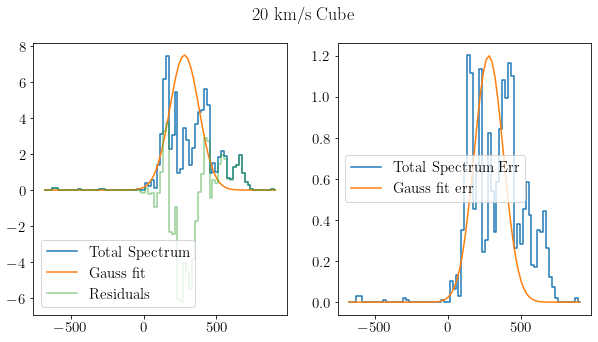

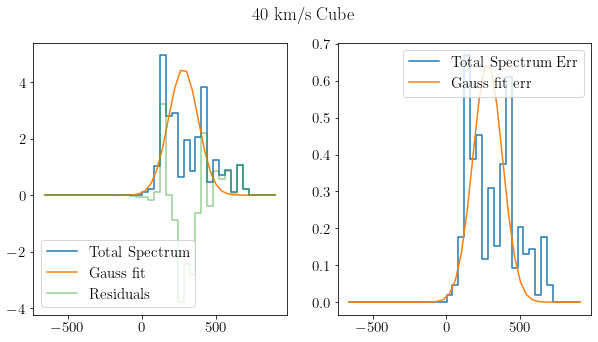

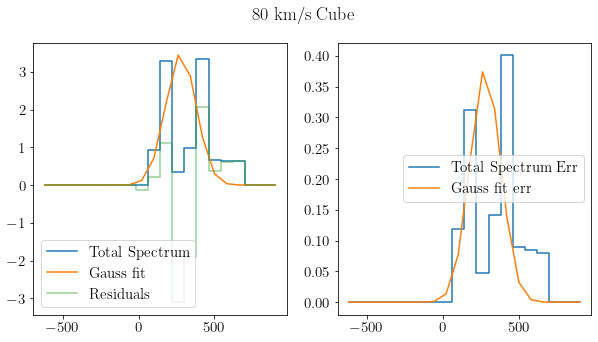

In [116]:
# Total Spectrum across velocity resolutions

mus = [350, 280, 280, 280]
sigmas = [130, 100, 100, 100]
amps = [9, 7.5, 4.5, 3.5]
err_amps = [2.2, 1.2, 0.65, 0.38]

tot_gintegrals = []
tot_gintegral_errs = []

tot_dintegrals = []
tot_dintegral_errs = []

for idt, tcube in enumerate(total_region_cubes):

        flux, flux_err, spectral_axis = af.extract_cube_spectrum(tcube, sigma_clip=3)

        fig, axes = plt.subplots(1,2, figsize=(10,5))
        axs = axes.ravel()

        ax = axs[0]
        ax.step(spectral_axis, flux, where='mid', label='Total Spectrum')
        mu, sigma, amp = mus[idt], sigmas[idt], amps[idt]
        ax.plot(spectral_axis, af.gauss(spectral_axis, mu, sigma, amp),
                label='Gauss fit')
        ax.step(spectral_axis, af.residuals(af.gauss(spectral_axis, mu, sigma, amp), flux), 
                        where='mid', alpha=0.5, label = 'Residuals')
        ax.legend()

        ax = axs[1]
        ax.step(spectral_axis, flux_err, where='mid', label='Total Spectrum Err')
        mu_err, sigma_err, amp_err = mus[idt], sigmas[idt], err_amps[idt]
        ax.plot(spectral_axis, af.gauss(spectral_axis, mu_err, sigma_err, amp_err), 
                label='Gauss fit err')
        ax.legend()

        fig.suptitle('{} km/s Cube'.format(velocity_resolutions[idt]))

        #estimate gaussian integral
        gauss_integral = af.gauss_integral(min(spectral_axis), max(spectral_axis),  mu=mu, sigma=sigma, amp=amp)
        gauss_integral_err = af.gauss_integral(min(spectral_axis), max(spectral_axis),  mu=mu_err, sigma=sigma_err, amp=amp_err)

        #estimate direct integral
        direct_integral = np.trapz(flux, spectral_axis)
        direct_integral_err = np.trapz(flux_err, spectral_axis)

        tot_gintegrals.append(gauss_integral[0])
        tot_gintegral_errs.append(gauss_integral_err[0])
        tot_dintegrals.append(direct_integral)
        tot_dintegral_errs.append(direct_integral_err)


In [117]:
total_masses = []
for idv, vres in enumerate(velocity_resolutions):

    print("\n Velocity resolution: {} km/s".format(vres))

    print("Gaussian integral: {}".format(tot_gintegrals[idv]))
    integral_units = ((u.mJy * u.km)/u.s)
    tot_mass = af.mass_time(tot_gintegrals[idv] * integral_units, 
                            tot_gintegral_errs[idv] * integral_units, 5)

    print("Direct integral: {}".format(tot_dintegrals[idv]))
    tot_mass_direct = af.mass_time(tot_dintegrals[idv] * integral_units, 
                            tot_dintegral_errs[idv] * integral_units, 5)

    total_masses.append(tot_mass)



 Velocity resolution: 10 km/s
Gaussian integral: 2932.724945210516
H2 mass: 6.51E+10 solMass +/- 1.59E+10 solMass
5.0 solMass / yr
t_dep : 1.30E+01 Gyr 
Direct integral: 2522.3272624484343
H2 mass: 5.60E+10 solMass +/- 1.66E+10 solMass
5.0 solMass / yr
t_dep : 1.12E+01 Gyr 

 Velocity resolution: 20 km/s
Gaussian integral: 1879.9712055501075
H2 mass: 4.17E+10 solMass +/- 6.68E+09 solMass
5.0 solMass / yr
t_dep : 8.34E+00 Gyr 
Direct integral: 1652.2122014290662
H2 mass: 3.67E+10 solMass +/- 8.21E+09 solMass
5.0 solMass / yr
t_dep : 7.33E+00 Gyr 

 Velocity resolution: 40 km/s
Gaussian integral: 1127.9827233271556
H2 mass: 2.50E+10 solMass +/- 3.62E+09 solMass
5.0 solMass / yr
t_dep : 5.01E+00 Gyr 
Direct integral: 1046.956275463094
H2 mass: 2.32E+10 solMass +/- 3.68E+09 solMass
5.0 solMass / yr
t_dep : 4.65E+00 Gyr 

 Velocity resolution: 80 km/s
Gaussian integral: 877.3198959165738
H2 mass: 1.95E+10 solMass +/- 2.11E+09 solMass
5.0 solMass / yr
t_dep : 3.89E+00 Gyr 
Direct integral: 

In [118]:
#sum of all parts
# #(1.7e10 +1.24e10 + 1.4e10 - 3.67e10)/1e9
#3.67e10 - 

#### Multi gaussian total fit

In [120]:
def multi_gaussian_fit(xdata, mus, sigmas, amps):
    mg_fit = af.gauss(xdata, mus[0], sigmas[0], amps[0]) 
    
    for idm, mu in enumerate(mus):
        if idm > 0:
            mg_fit += af.gauss(xdata, mus[idm], sigmas[idm], amps[idm]) 
    return mg_fit

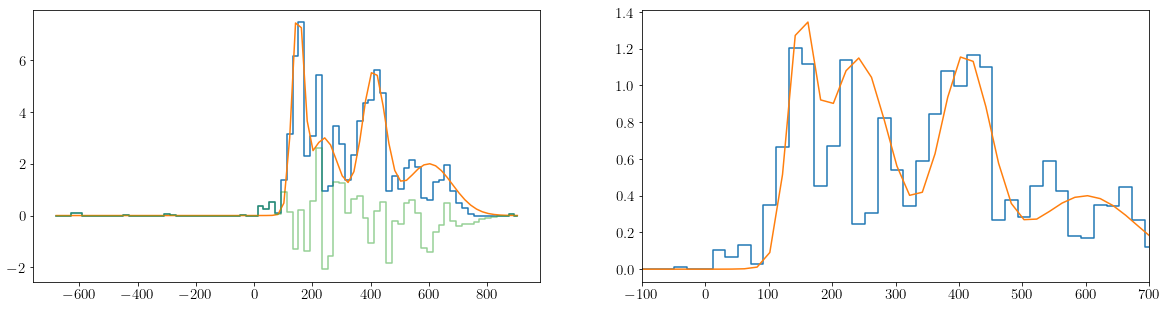

In [121]:
# Total Spectrum across velocity resolutions

mus = [150, 240, 410, 600]
sigmas = [20, 50, 40, 80]
amps = [7.6, 3, 5.5, 2.]
err_amps = [1.2, 1.15, 1.15, 0.4]


# for idt, tcube in enumerate(total_region_cubes):
tcube = total_region_cubes[1]
flux, flux_err, spectral_axis = af.extract_cube_spectrum(tcube, sigma_clip=3)

fig, axes = plt.subplots(1,2, figsize=(20,5))
axs = axes.ravel()

ax = axs[0]
ax.step(spectral_axis, flux, where='mid', label='Total Spectrum')
mg_fit = multi_gaussian_fit(spectral_axis, mus, sigmas, amps)
# mg_fit = (af.gauss(spectral_axis, mus[0], sigmas[0], amps[0]) + 
#                 af.gauss(spectral_axis, mus[1], sigmas[1], amps[1] )+ 
#                 af.gauss(spectral_axis, mus[2], sigmas[2], amps[2]) + 
#                 af.gauss(spectral_axis, mus[3], sigmas[3], amps[3]))
ax.plot(spectral_axis, mg_fit,
        label='Gauss fit')
ax.step(spectral_axis, af.residuals(mg_fit, flux), 
                where='mid', alpha=0.5, label = 'Residuals')
#ax.legend()
# ax.set_xlim(300,800)
ax = axs[1]
ax.step(spectral_axis, flux_err, where='mid', label='Total Spectrum Err')
mg_fit_err = (af.gauss(spectral_axis, mus[0], sigmas[0], err_amps[0]) + 
                af.gauss(spectral_axis, mus[1], sigmas[1], err_amps[1] )+ 
                af.gauss(spectral_axis, mus[2], sigmas[2], err_amps[2])+ 
                af.gauss(spectral_axis, mus[3], sigmas[3], err_amps[3]))
ax.plot(spectral_axis, mg_fit_err, 
        label='Gauss fit err')
#ax.legend()
ax.set_xlim(-100,700)

# fig.suptitle('{} km/s Cube'.format(velocity_resolutions[idt]))

#estimate gaussian integral
gauss_integral = (af.gauss_integral(min(spectral_axis), max(spectral_axis),  mu=mus[0], sigma=sigmas[0], amp=amps[0]) + 
                        af.gauss_integral(min(spectral_axis), max(spectral_axis),  mu=mus[1], sigma=sigmas[1], amp=amps[1]) + 
                        af.gauss_integral(min(spectral_axis), max(spectral_axis),  mu=mus[2], sigma=sigmas[2], amp=amps[2]))
gauss_integral_err = (af.gauss_integral(min(spectral_axis), max(spectral_axis),  mu=mus[0], sigma=sigmas[0], amp=err_amps[0]) + 
                        af.gauss_integral(min(spectral_axis), max(spectral_axis),  mu=mus[1], sigma=sigmas[1], amp=err_amps[1]) + 
                        af.gauss_integral(min(spectral_axis), max(spectral_axis),  mu=mus[2], sigma=sigmas[2], amp=err_amps[2]))
#estimate direct integral
direct_integral = np.trapz(flux, spectral_axis)
direct_integral_err = np.trapz(flux_err, spectral_axis)

# tot_gintegrals.append(gauss_integral[0])
# tot_gintegral_errs.append(gauss_integral_err[0])
# tot_dintegrals.append(direct_integral)
# tot_dintegral_errs.append(direct_integral_err)


In [90]:
print("Gaussian integral: {}".format(gauss_integral[0]))
integral_units = ((u.mJy * u.km)/u.s)
tot_mass = af.mass_time(gauss_integral[0] * integral_units, 
                        gauss_integral_err[0] * integral_units, 5)

print("Direct integral: {}".format(direct_integral))
tot_mass_direct = af.mass_time(direct_integral * integral_units, 
                        direct_integral_err * integral_units, 5)



Gaussian integral: 381.00749774391204
H2 mass: 8.46E+09 solMass +/- 1.34E+09 solMass
5.0 solMass / yr
t_dep : 1.69E+00 Gyr 
Direct integral: 1652.2122014290662
H2 mass: 3.67E+10 solMass +/- 8.21E+09 solMass
5.0 solMass / yr
t_dep : 7.33E+00 Gyr 


## B. Distribution of Gas Mass Throughout Regions

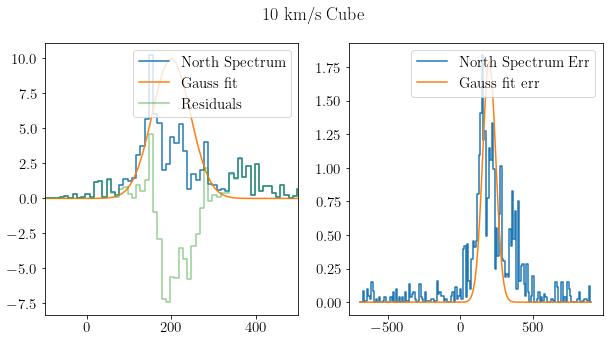

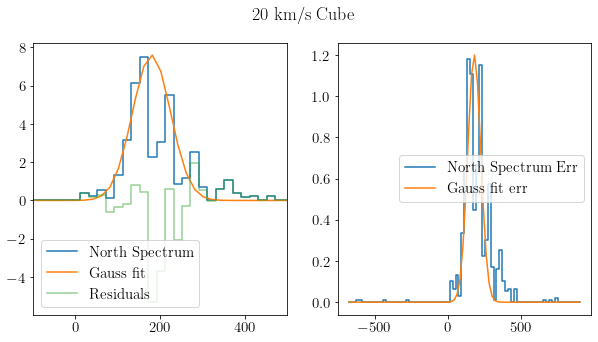

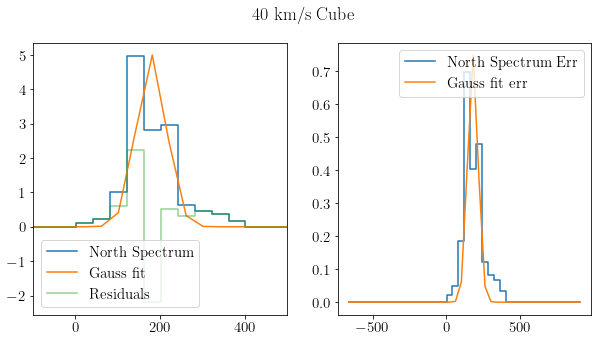

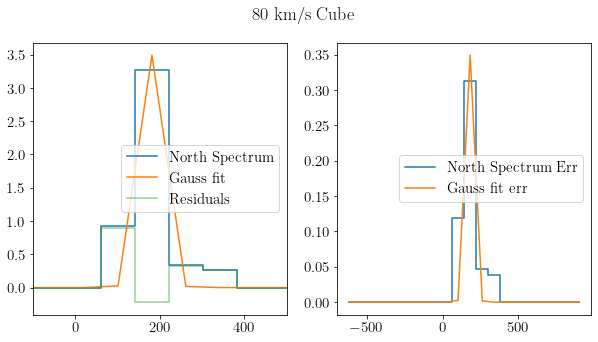

In [113]:
# North Spectrum across velocity resolutions

mus = [200, 180, 180, 180]
sigmas = [45, 45, 35, 25]
amps = [10, 7.6, 5, 3.5]
err_amps = [1.8, 1.2, 0.75, 0.35]

north_gintegrals = []
north_gintegral_errs = []

north_dintegrals = []
north_dintegral_errs = []

for idt, cube in enumerate(north_region_cubes):

        flux, flux_err, spectral_axis = af.extract_cube_spectrum(cube, sigma_clip=3)

        fig, axes = plt.subplots(1,2, figsize=(10,5))
        axs = axes.ravel()

        ax = axs[0]
        ax.step(spectral_axis, flux, where='mid', label='North Spectrum')
        mu, sigma, amp = mus[idt], sigmas[idt], amps[idt]
        ax.plot(spectral_axis, af.gauss(spectral_axis, mu, sigma, amp),
                label='Gauss fit')
        ax.step(spectral_axis, af.residuals(af.gauss(spectral_axis, mu, sigma, amp), flux), 
                        where='mid', alpha=0.5, label = 'Residuals')
        ax.legend()
        ax.set_xlim(-100,500)

        ax = axs[1]
        ax.step(spectral_axis, flux_err, where='mid', label='North Spectrum Err')
        mu_err, sigma_err, amp_err = mus[idt], sigmas[idt], err_amps[idt]
        ax.plot(spectral_axis, af.gauss(spectral_axis, mu_err, sigma_err, amp_err), 
                label='Gauss fit err')
        ax.legend()

        fig.suptitle('{} km/s Cube'.format(velocity_resolutions[idt]))

        #estimate gaussian integral
        gauss_integral = af.gauss_integral(min(spectral_axis), max(spectral_axis),  mu=mu, sigma=sigma, amp=amp)
        gauss_integral_err = af.gauss_integral(min(spectral_axis), max(spectral_axis),  mu=mu_err, sigma=sigma_err, amp=amp_err)

        #estimate direct integral
        direct_integral = np.trapz(flux, spectral_axis)
        direct_integral_err = np.trapz(flux_err, spectral_axis)

        north_gintegrals.append(gauss_integral[0])
        north_gintegral_errs.append(gauss_integral_err[0])
        north_dintegrals.append(direct_integral)
        north_dintegral_errs.append(direct_integral_err)


In [114]:
north_masses = []
for idv, vres in enumerate(velocity_resolutions):

    print("\n Velocity resolution: {} km/s".format(vres))

    print("Gaussian integral: {}".format(north_gintegrals[idv]))
    integral_units = ((u.mJy * u.km)/u.s)
    north_mass = af.mass_time(north_gintegrals[idv] * integral_units, 
                            north_gintegral_errs[idv] * integral_units, 5)

    print("Direct integral: {}".format(north_dintegrals[idv]))
    north_mass_direct = af.mass_time(north_dintegrals[idv] * integral_units, 
                            north_dintegral_errs[idv] * integral_units, 5)

    north_masses.append(north_mass)



 Velocity resolution: 10 km/s
Gaussian integral: 1127.9827235839502
H2 mass: 2.50E+10 solMass +/- 4.51E+09 solMass
5.0 solMass / yr
t_dep : 5.01E+00 Gyr 
Direct integral: 1077.8491498210133
H2 mass: 2.39E+10 solMass +/- 6.64E+09 solMass
5.0 solMass / yr
t_dep : 4.78E+00 Gyr 

 Velocity resolution: 20 km/s
Gaussian integral: 857.2668699238022
H2 mass: 1.90E+10 solMass +/- 3.00E+09 solMass
5.0 solMass / yr
t_dep : 3.80E+00 Gyr 
Direct integral: 772.0797804825927
H2 mass: 1.71E+10 solMass +/- 3.53E+09 solMass
5.0 solMass / yr
t_dep : 3.43E+00 Gyr 

 Velocity resolution: 40 km/s
Gaussian integral: 438.6599480604251
H2 mass: 9.73E+09 solMass +/- 1.46E+09 solMass
5.0 solMass / yr
t_dep : 1.95E+00 Gyr 
Direct integral: 550.4719505357864
H2 mass: 1.22E+10 solMass +/- 1.91E+09 solMass
5.0 solMass / yr
t_dep : 2.44E+00 Gyr 

 Velocity resolution: 80 km/s
Gaussian integral: 219.32997403021247
H2 mass: 4.87E+09 solMass +/- 4.87E+08 solMass
5.0 solMass / yr
t_dep : 9.73E-01 Gyr 
Direct integral: 3

##### Multi gaussian north fit


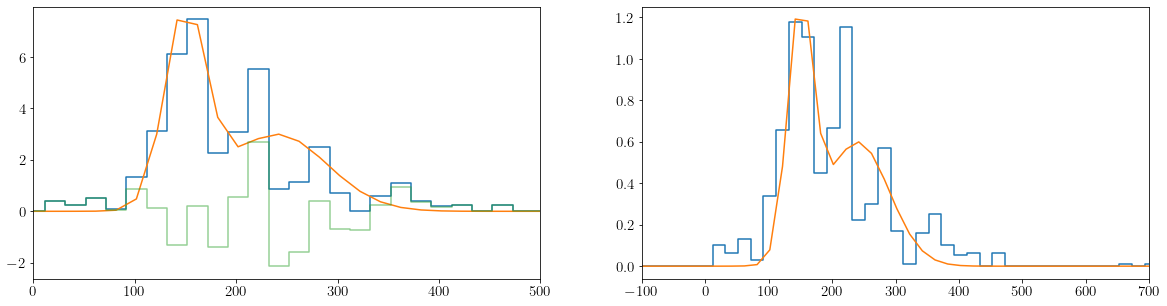

In [101]:
# NorthSpectrum across velocity resolutions

mus = [150, 240]
sigmas = [20, 50]
amps = [7.6, 3]
err_amps = [1.2, 0.6]


# for idt, tcube in enumerate(total_region_cubes):
ncube = north_region_cubes[1]
flux, flux_err, spectral_axis = af.extract_cube_spectrum(ncube, sigma_clip=3)

fig, axes = plt.subplots(1,2, figsize=(20,5))
axs = axes.ravel()

ax = axs[0]
ax.step(spectral_axis, flux, where='mid', label='Total Spectrum')
mg_fit = (af.gauss(spectral_axis, mus[0], sigmas[0], amps[0]) + 
                af.gauss(spectral_axis, mus[1], sigmas[1], amps[1] )) #+ 
                # af.gauss(spectral_axis, mus[2], sigmas[2], amps[2]) + 
                # af.gauss(spectral_axis, mus[3], sigmas[3], amps[3]))
ax.plot(spectral_axis, mg_fit,
        label='Gauss fit')
ax.step(spectral_axis, af.residuals(mg_fit, flux), 
                where='mid', alpha=0.5, label = 'Residuals')
#ax.legend()
ax.set_xlim(0,500)
ax = axs[1]
ax.step(spectral_axis, flux_err, where='mid', label='Total Spectrum Err')
mg_fit_err = (af.gauss(spectral_axis, mus[0], sigmas[0], err_amps[0]) + 
                af.gauss(spectral_axis, mus[1], sigmas[1], err_amps[1] ))#+ 
                # af.gauss(spectral_axis, mus[2], sigmas[2], err_amps[2])+ 
                # af.gauss(spectral_axis, mus[3], sigmas[3], err_amps[3]))
ax.plot(spectral_axis, mg_fit_err, 
        label='Gauss fit err')
#ax.legend()
ax.set_xlim(-100,700)

# fig.suptitle('{} km/s Cube'.format(velocity_resolutions[idt]))

#estimate gaussian integral
gauss_integral = (af.gauss_integral(min(spectral_axis), max(spectral_axis),  mu=mus[0], sigma=sigmas[0], amp=amps[0]) + 
                        af.gauss_integral(min(spectral_axis), max(spectral_axis),  mu=mus[1], sigma=sigmas[1], amp=amps[1]) )
gauss_integral_err = (af.gauss_integral(min(spectral_axis), max(spectral_axis),  mu=mus[0], sigma=sigmas[0], amp=err_amps[0]) + 
                        af.gauss_integral(min(spectral_axis), max(spectral_axis),  mu=mus[1], sigma=sigmas[1], amp=err_amps[1]))
#estimate direct integral
direct_integral = np.trapz(flux, spectral_axis)
direct_integral_err = np.trapz(flux_err, spectral_axis)

# tot_gintegrals.append(gauss_integral[0])
# tot_gintegral_errs.append(gauss_integral_err[0])
# tot_dintegrals.append(direct_integral)
# tot_dintegral_errs.append(direct_integral_err)


In [102]:
print("Gaussian integral: {}".format(gauss_integral[0]))
integral_units = ((u.mJy * u.km)/u.s)
n_mass = af.mass_time(gauss_integral[0] * integral_units, 
                        gauss_integral_err[0] * integral_units, 5)

print("Direct integral: {}".format(direct_integral))
nmass_direct = af.mass_time(direct_integral * integral_units, 
                        direct_integral_err * integral_units, 5)



Gaussian integral: 381.00749774391204
H2 mass: 8.46E+09 solMass +/- 1.34E+09 solMass
5.0 solMass / yr
t_dep : 1.69E+00 Gyr 
Direct integral: 772.0797804825927
H2 mass: 1.71E+10 solMass +/- 3.53E+09 solMass
5.0 solMass / yr
t_dep : 3.43E+00 Gyr 


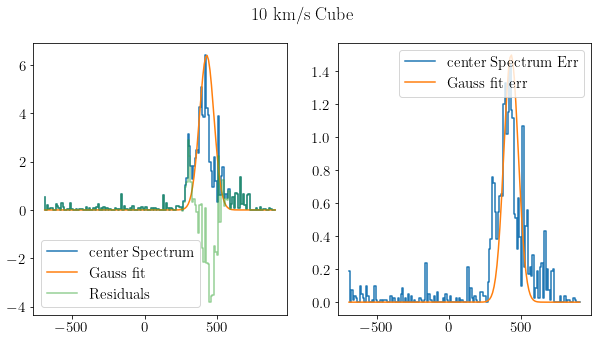

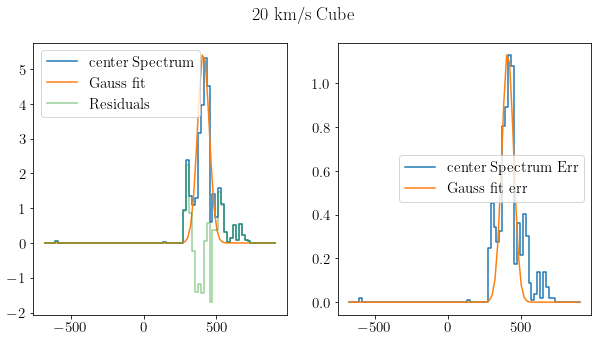

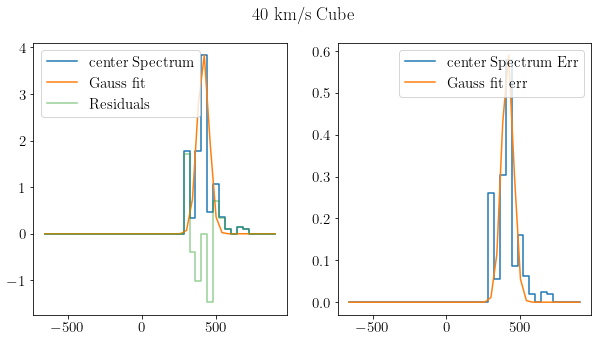

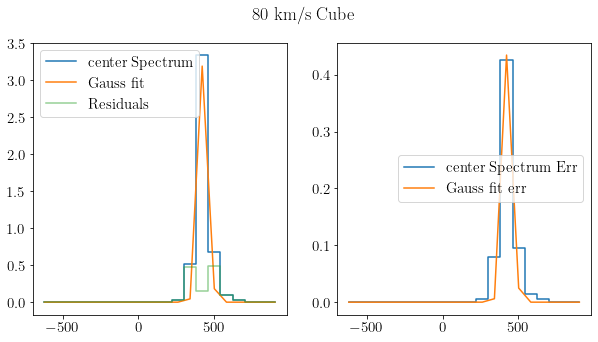

In [106]:
# center Spectrum across velocity resolutions

mus = [430, 410, 415, 430]
sigmas = [50, 40, 40, 30]
amps = [6.4, 5.5, 3.9, 3.3]
err_amps = [1.5, 1.15, 0.6, 0.45]

center_gintegrals = []
center_gintegral_errs = []

center_dintegrals = []
center_dintegral_errs = []

for idt, cube in enumerate(center_region_cubes):

        flux, flux_err, spectral_axis = af.extract_cube_spectrum(cube, sigma_clip=3)

        fig, axes = plt.subplots(1,2, figsize=(10,5))
        axs = axes.ravel()

        ax = axs[0]
        ax.step(spectral_axis, flux, where='mid', label='center Spectrum')
        mu, sigma, amp = mus[idt], sigmas[idt], amps[idt]
        ax.plot(spectral_axis, af.gauss(spectral_axis, mu, sigma, amp),
                label='Gauss fit')
        ax.step(spectral_axis, af.residuals(af.gauss(spectral_axis, mu, sigma, amp), flux), 
                        where='mid', alpha=0.5, label = 'Residuals')
        ax.legend()

        ax = axs[1]
        ax.step(spectral_axis, flux_err, where='mid', label='center Spectrum Err')
        mu_err, sigma_err, amp_err = mus[idt], sigmas[idt], err_amps[idt]
        ax.plot(spectral_axis, af.gauss(spectral_axis, mu_err, sigma_err, amp_err), 
                label='Gauss fit err')
        ax.legend()

        fig.suptitle('{} km/s Cube'.format(velocity_resolutions[idt]))

        #estimate gaussian integral
        gauss_integral = af.gauss_integral(min(spectral_axis), max(spectral_axis),  mu=mu, sigma=sigma, amp=amp)
        gauss_integral_err = af.gauss_integral(min(spectral_axis), max(spectral_axis),  mu=mu_err, sigma=sigma_err, amp=amp_err)

        #estimate direct integral
        direct_integral = np.trapz(flux, spectral_axis)
        direct_integral_err = np.trapz(flux_err, spectral_axis)

        center_gintegrals.append(gauss_integral[0])
        center_gintegral_errs.append(gauss_integral_err[0])
        center_dintegrals.append(direct_integral)
        center_dintegral_errs.append(direct_integral_err)


In [107]:
center_masses = []
for idv, vres in enumerate(velocity_resolutions):

    print("\n Velocity resolution: {} km/s".format(vres))

    print("Gaussian integral: {}".format(center_gintegrals[idv]))
    integral_units = ((u.mJy * u.km)/u.s)
    center_mass = af.mass_time(center_gintegrals[idv] * integral_units, 
                            center_gintegral_errs[idv] * integral_units, 5)

    print("Direct integral: {}".format(center_dintegrals[idv]))
    center_mass_direct = af.mass_time(center_dintegrals[idv] * integral_units, 
                            center_dintegral_errs[idv] * integral_units, 5)

    center_masses.append(center_mass)



 Velocity resolution: 10 km/s
Gaussian integral: 802.1210478819204
H2 mass: 1.78E+10 solMass +/- 4.17E+09 solMass
5.0 solMass / yr
t_dep : 3.56E+00 Gyr 
Direct integral: 835.7551860266608
H2 mass: 1.85E+10 solMass +/- 5.38E+09 solMass
5.0 solMass / yr
t_dep : 3.71E+00 Gyr 

 Velocity resolution: 20 km/s
Gaussian integral: 551.4582204188201
H2 mass: 1.22E+10 solMass +/- 2.56E+09 solMass
5.0 solMass / yr
t_dep : 2.45E+00 Gyr 
Direct integral: 633.8058110326513
H2 mass: 1.41E+10 solMass +/- 3.38E+09 solMass
5.0 solMass / yr
t_dep : 2.81E+00 Gyr 

 Velocity resolution: 40 km/s
Gaussian integral: 391.0340108424361
H2 mass: 8.68E+09 solMass +/- 1.34E+09 solMass
5.0 solMass / yr
t_dep : 1.74E+00 Gyr 
Direct integral: 399.15604074033575
H2 mass: 8.86E+09 solMass +/- 1.40E+09 solMass
5.0 solMass / yr
t_dep : 1.77E+00 Gyr 

 Velocity resolution: 80 km/s
Gaussian integral: 248.15619918846897
H2 mass: 5.51E+09 solMass +/- 7.51E+08 solMass
5.0 solMass / yr
t_dep : 1.10E+00 Gyr 
Direct integral: 37

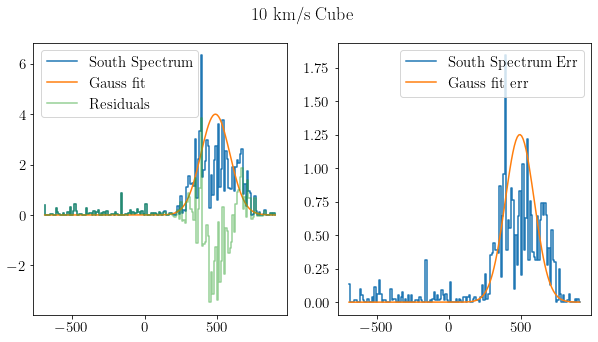

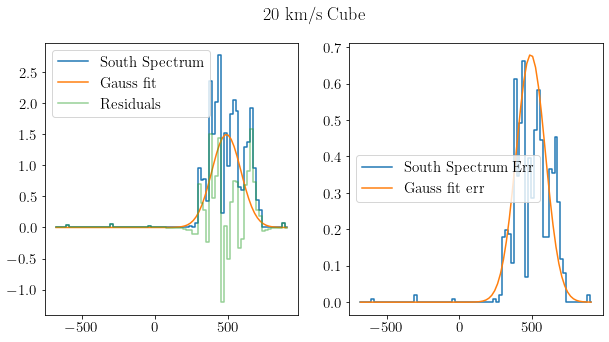

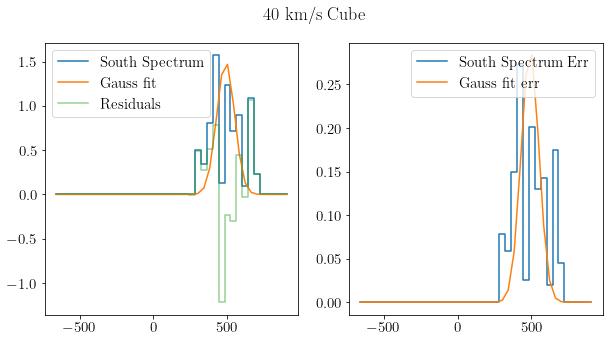

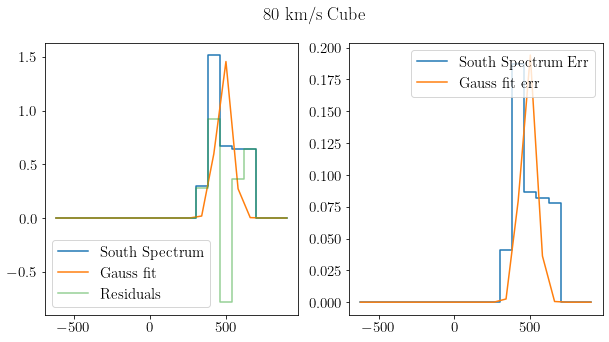

In [110]:
# South Spectrum across velocity resolutions

mus = [490, 490, 490, 490]
sigmas = [100, 100, 60, 50]
amps = [4, 1.5, 1.5, 1.5]
err_amps = [1.25, 0.68, 0.29, 0.2]

south_gintegrals = []
south_gintegral_errs = []

south_dintegrals = []
south_dintegral_errs = []

for idt, cube in enumerate(south_region_cubes):

        flux, flux_err, spectral_axis = af.extract_cube_spectrum(cube, sigma_clip=3)

        fig, axes = plt.subplots(1,2, figsize=(10,5))
        axs = axes.ravel()

        ax = axs[0]
        ax.step(spectral_axis, flux, where='mid', label='South Spectrum')
        mu, sigma, amp = mus[idt], sigmas[idt], amps[idt]
        ax.plot(spectral_axis, af.gauss(spectral_axis, mu, sigma, amp),
                label='Gauss fit')
        ax.step(spectral_axis, af.residuals(af.gauss(spectral_axis, mu, sigma, amp), flux), 
                        where='mid', alpha=0.5, label = 'Residuals')
        ax.legend()

        ax = axs[1]
        ax.step(spectral_axis, flux_err, where='mid', label='South Spectrum Err')
        mu_err, sigma_err, amp_err = mus[idt], sigmas[idt], err_amps[idt]
        ax.plot(spectral_axis, af.gauss(spectral_axis, mu_err, sigma_err, amp_err), 
                label='Gauss fit err')
        ax.legend()

        fig.suptitle('{} km/s Cube'.format(velocity_resolutions[idt]))

        #estimate gaussian integral
        gauss_integral = af.gauss_integral(min(spectral_axis), max(spectral_axis),  mu=mu, sigma=sigma, amp=amp)
        gauss_integral_err = af.gauss_integral(min(spectral_axis), max(spectral_axis),  mu=mu_err, sigma=sigma_err, amp=amp_err)

        #estimate direct integral
        direct_integral = np.trapz(flux, spectral_axis)
        direct_integral_err = np.trapz(flux_err, spectral_axis)

        south_gintegrals.append(gauss_integral[0])
        south_gintegral_errs.append(gauss_integral_err[0])
        south_dintegrals.append(direct_integral)
        south_dintegral_errs.append(direct_integral_err)


In [111]:
south_masses = []
for idv, vres in enumerate(velocity_resolutions):

    print("\n Velocity resolution: {} km/s".format(vres))

    print("Gaussian integral: {}".format(south_gintegrals[idv]))
    integral_units = ((u.mJy * u.km)/u.s)
    south_mass = af.mass_time(south_gintegrals[idv] * integral_units, 
                            south_gintegral_errs[idv] * integral_units, 5)

    print("Direct integral: {}".format(south_dintegrals[idv]))
    south_mass_direct = af.mass_time(south_dintegrals[idv] * integral_units, 
                            south_dintegral_errs[idv] * integral_units, 5)

    south_masses.append(south_mass)



 Velocity resolution: 10 km/s
Gaussian integral: 1002.6336277615105
H2 mass: 2.23E+10 solMass +/- 6.95E+09 solMass
5.0 solMass / yr
t_dep : 4.45E+00 Gyr 
Direct integral: 919.5716639330449
H2 mass: 2.04E+10 solMass +/- 6.31E+09 solMass
5.0 solMass / yr
t_dep : 4.08E+00 Gyr 

 Velocity resolution: 20 km/s
Gaussian integral: 375.98758446076306
H2 mass: 8.34E+09 solMass +/- 3.78E+09 solMass
5.0 solMass / yr
t_dep : 1.67E+00 Gyr 
Direct integral: 560.7856462659839
H2 mass: 1.24E+10 solMass +/- 3.17E+09 solMass
5.0 solMass / yr
t_dep : 2.49E+00 Gyr 

 Velocity resolution: 40 km/s
Gaussian integral: 225.596544716159
H2 mass: 5.01E+09 solMass +/- 9.68E+08 solMass
5.0 solMass / yr
t_dep : 1.00E+00 Gyr 
Direct integral: 305.8229012318306
H2 mass: 6.79E+09 solMass +/- 1.16E+09 solMass
5.0 solMass / yr
t_dep : 1.36E+00 Gyr 

 Velocity resolution: 80 km/s
Gaussian integral: 187.99712059732502
H2 mass: 4.17E+09 solMass +/- 5.56E+08 solMass
5.0 solMass / yr
t_dep : 8.34E-01 Gyr 
Direct integral: 30

In [119]:
for idv, vres in enumerate(velocity_resolutions):
        print("\n for a velocity resolution of {} km/s, {:.1f}% of the gas is concentrated in the north, " \
                " {:.1f}% of the gas is concentrated in the center, and {:.1f}% of the gas is concentrated "\
                        "in the south".format(vres, north_masses[idv][0]*100/total_masses[idv][0], center_masses[idv][0]*100/total_masses[idv][0],
                                                                south_masses[idv][0]*100/total_masses[idv][0]))


 for a velocity resolution of 10 km/s, 38.5% of the gas is concentrated in the north,  27.4% of the gas is concentrated in the center, and 34.2% of the gas is concentrated in the south

 for a velocity resolution of 20 km/s, 45.6% of the gas is concentrated in the north,  29.3% of the gas is concentrated in the center, and 20.0% of the gas is concentrated in the south

 for a velocity resolution of 40 km/s, 38.9% of the gas is concentrated in the north,  34.7% of the gas is concentrated in the center, and 20.0% of the gas is concentrated in the south

 for a velocity resolution of 80 km/s, 25.0% of the gas is concentrated in the north,  28.3% of the gas is concentrated in the center, and 21.4% of the gas is concentrated in the south


In [104]:
(100-45)/2

27.5

## C. Does Weighting Impact Gas Mass?


In [56]:
#list of cubes
wcube_files = []
weights = ['briggs', 'natural']

wcube_files = [''.join((my_path, 'Analysis/almaBeads/reduced_2022/SDSS1531_CO32_20kms_{}_notaper'
                        '.image.pbcor.fits'.format(weight))) for weight in weights]

In [57]:
#moment files for each cube
#moment files for each cube
m0_files = [wfile[:-5]+ '_M0.fits' for wfile in wcube_files]
m1_files = [wfile[:-5]+ '_M1.fits' for wfile in wcube_files]
m2_files = [wfile[:-5]+ '_M2.fits' for wfile in wcube_files]

In [58]:
m0cmap, m1cmap, m2cmap =sns.light_palette("seagreen", as_cmap=True), cm.Blues,  sns.color_palette("mako_r", as_cmap=True)

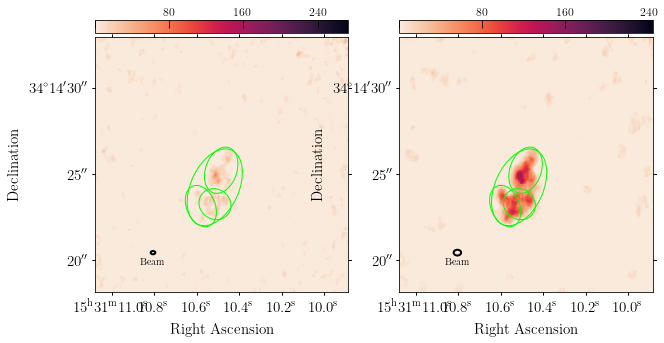

In [59]:
hdu, header, wcs = pf.open_fits(m0_files[0], naxis=2)
fig = pf.plot_all_moments(m0_files, header, region_string=region_string, ncols=2)

In [60]:
wregion_cubes = []

for idr, region_type in enumerate(regions):

    wap_cubes = []
    print('region: {}'.format(idr))

    for idw, wfile in enumerate(wcube_files):
        print('weight: {}'.format(idw))

        cube = SpectralCube.read(wfile)

        ap_cube = cube.subcube_from_regions(region_type) 

        wap_cubes.append(ap_cube)

    wregion_cubes.append(wap_cubes)
    print('region: {}'.format(idr))

region: 0
weight: 0
weight: 1
region: 0
region: 1
weight: 0
weight: 1
region: 1
region: 2
weight: 0
weight: 1
region: 2
region: 3
weight: 0
weight: 1
region: 3


In [61]:
wnorth_region_cubes = wregion_cubes[0]
wcenter_region_cubes = wregion_cubes[1]
wsouth_region_cubes = wregion_cubes[2]
wtotal_region_cubes = wregion_cubes[3]


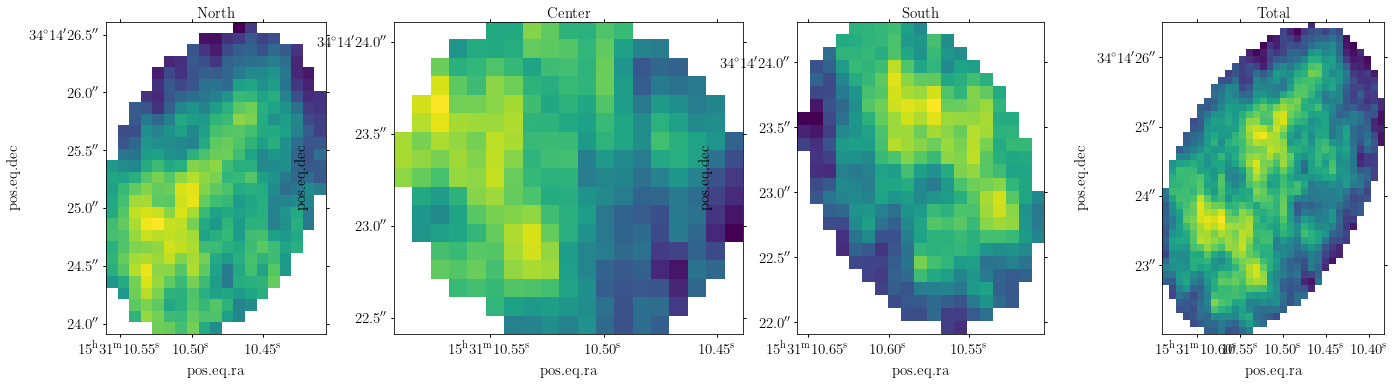

In [62]:
#check that the areas selected are correct
pf.styleplots()

fig = plt.figure(figsize=(20, 5))
gs1 = GridSpec(1,4)

wplot_cubes = [wnorth_region_cubes, wcenter_region_cubes, wsouth_region_cubes, wtotal_region_cubes]

for idx in range(4):
    wplot_cube = wplot_cubes[idx][1]

    ax = fig.add_subplot(gs1[idx], projection=WCS(wplot_cube.header), slices=('x', 'y', 0))
    ax.imshow(wplot_cube.moment(order=0).data)
    ax.set_title(region_names[idx])

fig.tight_layout()



#### Total Mass

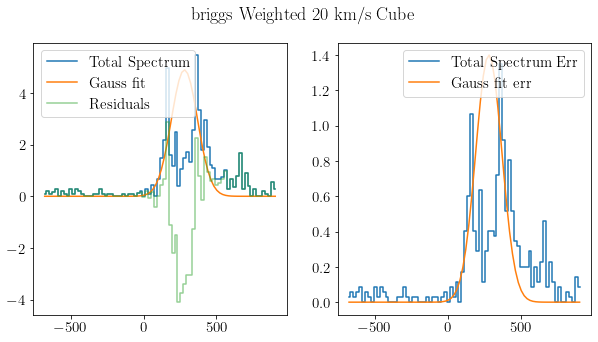

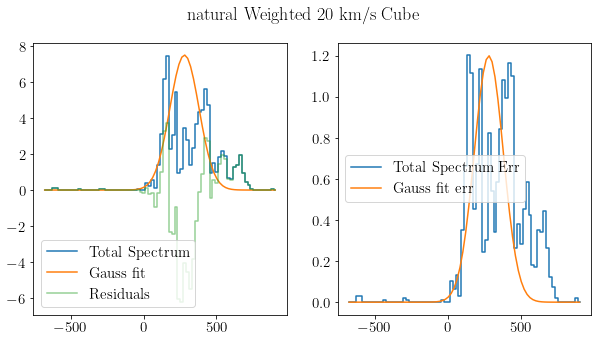

In [80]:
# Total Spectrum across velocity resolutions

mus = [280, 280]
sigmas = [90, 100]
amps = [4.9, 7.5]
err_amps = [1.4, 1.2]

wtot_gintegrals = []
wtot_gintegral_errs = []

wtot_dintegrals = []
wtot_dintegral_errs = []

for idt, tcube in enumerate(wtotal_region_cubes):

        flux, flux_err, spectral_axis = af.extract_cube_spectrum(tcube, sigma_clip=3)

        fig, axes = plt.subplots(1,2, figsize=(10,5))
        axs = axes.ravel()

        ax = axs[0]
        ax.step(spectral_axis, flux, where='mid', label='Total Spectrum')
        mu, sigma, amp = mus[idt], sigmas[idt], amps[idt]
        ax.plot(spectral_axis, af.gauss(spectral_axis, mu, sigma, amp),
                label='Gauss fit')
        ax.step(spectral_axis, af.residuals(af.gauss(spectral_axis, mu, sigma, amp), flux), 
                        where='mid', alpha=0.5, label = 'Residuals')
        ax.legend()

        ax = axs[1]
        ax.step(spectral_axis, flux_err, where='mid', label='Total Spectrum Err')
        mu_err, sigma_err, amp_err = mus[idt], sigmas[idt], err_amps[idt]
        ax.plot(spectral_axis, af.gauss(spectral_axis, mu_err, sigma_err, amp_err), 
                label='Gauss fit err')
        ax.legend()

        fig.suptitle('{} Weighted 20 km/s Cube'.format(weights[idt]))

        #estimate gaussian integral
        gauss_integral = af.gauss_integral(min(spectral_axis), max(spectral_axis),  mu=mu, sigma=sigma, amp=amp)
        gauss_integral_err = af.gauss_integral(min(spectral_axis), max(spectral_axis),  mu=mu_err, sigma=sigma_err, amp=amp_err)

        #estimate direct integral
        direct_integral = np.trapz(flux, spectral_axis)
        direct_integral_err = np.trapz(flux_err, spectral_axis)

        wtot_gintegrals.append(gauss_integral[0])
        wtot_gintegral_errs.append(gauss_integral_err[0])
        wtot_dintegrals.append(direct_integral)
        wtot_dintegral_errs.append(direct_integral_err)


In [81]:
wtotal_masses = []
for idw, weight in enumerate(weights):

    print("\n Weight: {} ".format(weight))

    print("Gaussian integral: {}".format(wtot_gintegrals[idw]))
    integral_units = ((u.mJy * u.km)/u.s)
    wtot_mass = af.mass_time(wtot_gintegrals[idw] * integral_units, 
                            wtot_gintegral_errs[idw] * integral_units, 5)

    print("Direct integral: {}".format(wtot_dintegrals[idw]))
    wtot_mass_direct = af.mass_time(wtot_dintegrals[idw] * integral_units, 
                            wtot_dintegral_errs[idw] * integral_units, 5)

    wtotal_masses.append(wtot_mass)



 Weight: briggs 
Gaussian integral: 1105.423069109919
H2 mass: 2.45E+10 solMass +/- 7.01E+09 solMass
5.0 solMass / yr
t_dep : 4.91E+00 Gyr 
Direct integral: 1099.616213003611
H2 mass: 2.44E+10 solMass +/- 6.53E+09 solMass
5.0 solMass / yr
t_dep : 4.88E+00 Gyr 

 Weight: natural 
Gaussian integral: 1879.9712055501075
H2 mass: 4.17E+10 solMass +/- 6.68E+09 solMass
5.0 solMass / yr
t_dep : 8.34E+00 Gyr 
Direct integral: 1652.2122014290662
H2 mass: 3.67E+10 solMass +/- 8.21E+09 solMass
5.0 solMass / yr
t_dep : 7.33E+00 Gyr 


In [87]:
print("Briggs weighting mass is {:.1f}% of natural weighting's mass".format(wtotal_masses[0][0] * 100/wtotal_masses[1][0]))

Briggs weighting mass is 58.8% of natural weighting's mass
